## Import Libraries and Frameworks

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn as sns
import pickle
import powerlaw

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

## Import Twitter Data

In [ ]:
notes = pd.read_csv('../data/notes-2022-02-21.tsv', sep="\t")
ratings = pd.read_csv('../data/ratings-2022-02-21.tsv', sep="\t")
tweets = pd.read_csv('../data/noted-tweets.csv', sep="\t")

## Import Processed Data

In [ ]:
with open('../data/processed.pickle', 'rb') as handle:
    dictionary = pickle.load(handle)

In [ ]:
dictionary.keys()

dict_keys(['notes 02/01/2021', 'tweets 02/01/2021', 'notes 03/01/2021', 'tweets 03/01/2021', 'notes 03/15/2021', 'tweets 03/15/2021', 'notes 04/01/2021', 'tweets 04/01/2021', 'notes 04/15/2021', 'tweets 04/15/2021', 'notes 05/01/2021', 'tweets 05/01/2021', 'notes 05/15/2021', 'tweets 05/15/2021', 'notes 06/01/2021', 'tweets 06/01/2021', 'notes 06/15/2021', 'tweets 06/15/2021', 'notes 07/01/2021', 'tweets 07/01/2021', 'notes 07/15/2021', 'tweets 07/15/2021', 'notes 08/01/2021', 'tweets 08/01/2021', 'notes 08/15/2021', 'tweets 08/15/2021', 'notes 09/01/2021', 'tweets 09/01/2021', 'notes 09/15/2021', 'tweets 09/15/2021', 'notes 10/01/2021', 'tweets 10/01/2021', 'notes 10/15/2021', 'tweets 10/15/2021', 'notes 11/01/2021', 'tweets 11/01/2021', 'notes 11/15/2021', 'tweets 11/15/2021', 'notes 12/01/2021', 'tweets 12/01/2021', 'notes 12/15/2021', 'tweets 12/15/2021', 'notes 01/01/2022', 'tweets 01/01/2022', 'notes 01/15/2022', 'tweets 01/15/2022', 'notes 02/01/2022', 'tweets 02/01/2022', 'note

In [ ]:
notesWithRatings = dictionary['notes 02/15/2022']

## Count Vectorizer

In [ ]:
cvec = CountVectorizer(min_df=.005, max_df=.9, ngram_range=(1,2), tokenizer=lambda doc: doc, lowercase=False)
cvec.fit(notesWithRatings['clean_summary'])

cvec_counts = cvec.transform(notesWithRatings['clean_summary'])
print('sparse matrix shape:', cvec_counts.shape)
print('nonzero count:', cvec_counts.nnz)
print('sparsity: %.2f%%' % (100.0 * cvec_counts.nnz / (cvec_counts.shape[0] * cvec_counts.shape[1])))

/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
sparse matrix shape: (25359, 552)
nonzero count: 213457
sparsity: 1.52%


In [ ]:
# Instantiating the TfidfTransformer
transformer = TfidfTransformer()

# Fitting and transforming n-grams
transformed_weights = transformer.fit_transform(cvec_counts)

In [ ]:
# Getting a list of all n-grams
transformed_weights = transformed_weights.toarray()
vocab = cvec.get_feature_names()

# Putting weighted n-grams into a DataFrame and computing some summary statistics
model = pd.DataFrame(transformed_weights, columns=vocab)
model['Keyword'] = model.idxmax(axis=1)
model['Max'] = model.max(axis=1)
model['Sum'] = model.drop('Max', axis=1).sum(axis=1)

model = pd.concat([notesWithRatings.reset_index(), model], axis=1)

/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## 25 Top Occurring Words

In [ ]:
# Getting a view of the top 25 occurring words
occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'Term': cvec.get_feature_names(), 'Occurrences': occ})
counts_df.sort_values(by='Occurrences', ascending=False).head(25)

,Term,Occurrences
109,covid,3686
504,tweet,3142
361,prediction,2732
515,vaccine,2687
267,like,2643
71,claim,2614
470,state,2307
145,earthquake,2185
153,election,2149
337,people,2097


In [ ]:
# Getting a view of the top 25 weights
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'Term': cvec.get_feature_names(), 'Weight': weights})
weights_df.sort_values(by='Weight', ascending=False).head(25)

/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Term,Weight
504,tweet,0.031195
109,covid,0.028754
71,claim,0.024264
515,vaccine,0.024116
312,not,0.019915
337,people,0.019615
159,evidence,0.018810
470,state,0.018203
166,fact,0.016913
267,like,0.016534


0.0    10632
1.0     7229
Name: helpful_quant, dtype: int64


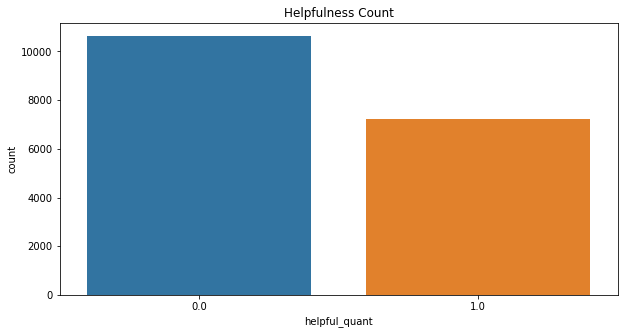

In [ ]:
# Plotting overall value counts of helpful categories
fig = plt.figure(figsize = (10,5))
sns.countplot(x='helpful_quant', data = model).set_title('Helpfulness Count')

print(notesWithRatings['helpful_quant'].value_counts())

helpful_quant
0.0    0.593868
1.0    0.856135
Name: has_links, dtype: float64

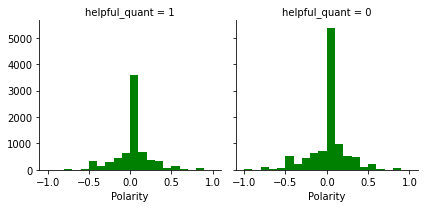

In [ ]:
# Visualizing value counts of helpful compared to their polarity and subjectivity scores.
g = sns.FacetGrid(model, col="helpful_quant", col_order=[1, 0])
g = g.map(plt.hist, "Polarity", bins=20, color="g")

recommend = model.groupby(['helpful_quant'])
recommend['has_links'].mean()

helpful_quant
0.0    0.338485
1.0    0.341273
Name: Subjectivity, dtype: float64

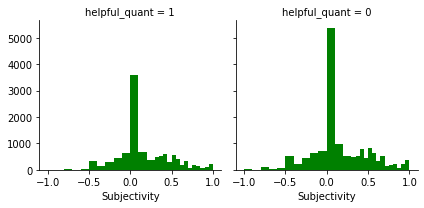

In [ ]:
g = g.map(plt.hist, "Subjectivity", bins=20, color="g")
recommend['Subjectivity'].mean()

Text(0.5, 1.0, 'Links vs. helpfulness score')

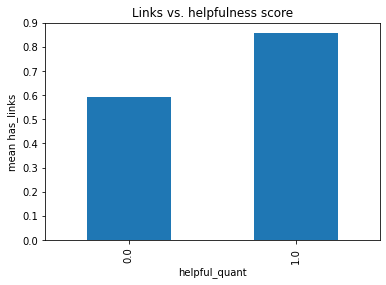

In [ ]:
recommend['has_links'].mean().plot(kind='bar', yticks=np.arange(0, 1, 0.1), ylabel="mean has_links").set_title('Links vs. helpfulness score')

In [ ]:
model.columns[63:]

Index(['accord', 'accord numerous', 'account', 'account post', 'accurate',
       'act', 'action', 'activist', 'actual', 'actually',
       ...
       'worker', 'world', 'write', 'wrong', 'year', 'young', 'zero', 'Keyword',
       'Max', 'Sum'],
      dtype='object', length=555)

In [ ]:
X = model.drop(model.columns[:63], axis=1)
X = X.drop(['Keyword', 'Max', 'Sum'], axis=1)
y_helpful = model['helpful_quant'] == 1

In [ ]:
X

,accord,accord numerous,account,account post,accurate,act,action,activist,actual,actually,...,woman,word,work,worker,world,write,wrong,year,young,zero
0,0.0,0.0,0.285093,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25354,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25355,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25356,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25357,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_train_help, X_test_help, y_train_help, y_test_help = train_test_split(X, y_helpful, test_size = 0.3, random_state=0)

In [ ]:
# Defining a function to fit and predict ML algorithms
def model_help(mod, model_name, x_train, y_train, x_test, y_test):
    mod.fit(x_train, y_train)
    print(model_name)
    acc = cross_val_score(mod, x_train, y_train, scoring = "accuracy", cv = 5)
    predictions = cross_val_predict(mod, x_train, y_train, cv = 5)
    if y_train.mean() < 0.5:
        print("Guess Most Frequent Label ", 1-y_train.mean(), 1-y_test.mean()) 
    else:
         print("Guess Most Frequent Label ", y_train.mean(), y_test.mean())
    print("Accuracy:", round(acc.mean(),3))
    cm = confusion_matrix(predictions, y_train)
    print("Confusion Matrix:  \n", cm)
    print("                    Classification Report \n",classification_report(predictions, y_train))

In [ ]:
gnb = GaussianNB()
ran = RandomForestClassifier(n_estimators=50)
log = LogisticRegression()
svc = LinearSVC()

models = [gnb, ran, log, svc]
model_names = ["Gaussian", "Random Forest", "Logistic Regression", "Linear SVC"]

In [ ]:
X_train_help.columns[X_train_help.isna().any()].tolist()

[]

In [ ]:
for i in range(len(models)):
    model_help(models[i], model_names[i], X_train_help, y_train_help, X_test_help, y_test_help)

Gaussian
Guess Most Frequent Label  0.7166920173511351 0.7108307045215563
Accuracy: 0.493
Confusion Matrix:  
 [[4910 1191]
 [7812 3838]]
                    Classification Report 
               precision    recall  f1-score   support

       False       0.39      0.80      0.52      6101
        True       0.76      0.33      0.46     11650

    accuracy                           0.49     17751
   macro avg       0.57      0.57      0.49     17751
weighted avg       0.63      0.49      0.48     17751

Random Forest
Guess Most Frequent Label  0.7166920173511351 0.7108307045215563
Accuracy: 0.705
Confusion Matrix:  
 [[11891  4398]
 [  831   631]]
                    Classification Report 
               precision    recall  f1-score   support

       False       0.93      0.73      0.82     16289
        True       0.13      0.43      0.19      1462

    accuracy                           0.71     17751
   macro avg       0.53      0.58      0.51     17751
weighted avg       0.87     

## Plotting Word Feature Importance

/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/axisgrid.py:1209: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


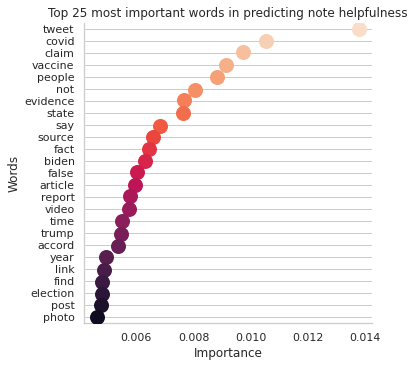

In [ ]:
# Creating a plot for feature importance
def importance_plotting(data,x,y,palette,title):
    sns.set(style="whitegrid")
    ft = sns.PairGrid(data,y_vars=y,x_vars=x,size=5,aspect=1)
    ft.map(sns.stripplot,orient='h',palette=palette, edgecolor="black",size=15)
    for ax, title in zip(ft.axes.flat, titles):
        
    # Set a different title for each axes
        ax.set(title=title)
        
    # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)

    plt.show()

# Compile arrays of columns (words) and feature importances
# fi = {'Words':model.drop('helpful',axis=1).columns.tolist(),'Importance':log.coef_[0]}
fi = {'Words':X.columns.tolist(),'Importance':ran.feature_importances_}

# Bung these into a dataframe, rank highest to lowest then slice top 25
Importance = pd.DataFrame(fi,index=None).sort_values('Importance',ascending=False).head(25)

# Plot the graph
titles = ["Top 25 most important words in predicting note helpfulness"]
importance_plotting(Importance,'Importance','Words','rocket_r',titles)

## Helpfulness vs Time

In [ ]:
dates = [
    # LAST_DATE,
    '03/01/2021', '03/15/2021', 
    '04/01/2021', '04/15/2021',
    '05/01/2021', '05/15/2021', 
    '06/01/2021', '06/15/2021',
    '07/01/2021', '07/15/2021',
    '08/01/2021', '08/15/2021', 
    '09/01/2021', '09/15/2021',
    '10/01/2021', '10/15/2021',
    '11/01/2021', '11/15/2021',
    '12/01/2021', '12/15/2021',
    '01/01/2022', '01/15/2022',
    '02/01/2022', '02/15/2022']
helpfulness = []
for date in dates:
    notes = dictionary['notes ' + date]
    avg = len(notes.loc[notes['helpful_quant'] == 1]) / len(notes)
    helpfulness.append(avg)

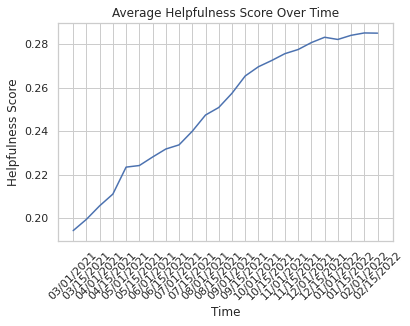

In [ ]:
df = pd.DataFrame({"Time": dates,
                   "Helpfulness Score": helpfulness})
sns.lineplot(x="Time", y="Helpfulness Score", data=df)
plt.xticks(rotation=45)
plt.title('Average Helpfulness Score Over Time')
plt.show()

## Power Law Distribution?

In [ ]:
notes_count = notes['participantId'].value_counts()
ratings_count = ratings['participantId'].value_counts()

In [ ]:
rating_results = powerlaw.Fit(ratings_count)
print(rating_results.power_law.alpha)
print(rating_results.power_law.xmin)
R, p = rating_results.distribution_compare('power_law', 'lognormal')
print('log likelihood: ', R)
print('significance of R', p)

Calculating best minimal value for power law fit
2.6928605541908017
92.0
log likelihood:  -0.024975733531483968
significance of R 0.8880043437875454


In [ ]:
np.seterr(divide='ignore', invalid='ignore')
notes_results = powerlaw.Fit(notes_count)
print(notes_results.power_law.alpha)
print(notes_results.power_law.xmin)
R, p = notes_results.distribution_compare('power_law', 'lognormal')
print('log likelihood: ', R)
print('significance of R', p)

Calculating best minimal value for power law fit
2.3726276889912463
13.0
log likelihood:  -0.8624197637218494
significance of R 0.1197403087970569
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Text(0, 0.5, 'p(X), p(X>=x)')

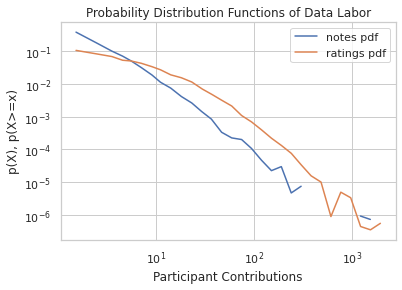

In [ ]:
plot = powerlaw.plot_pdf(notes_count)
powerlaw.plot_pdf(ratings_count, plot)
plot.set_title("Probability Distribution Functions of Data Labor")
plot.legend(['notes pdf', 'ratings pdf'])
plot.set_xlabel("Participant Contributions")
plot.set_ylabel("p(X), p(X>=x)")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c0e62a2c-7f45-414e-8164-5bf51e09d482' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>